# Data Augmentation

## 1. Text preprocessing

### 1.1. 맞춤법 처리 여부
hanspell의 spell_checker를 돌리게 되면 많은 시간이 소모되는데 (`train.csv`에 대해 약 10분), 

실질적으로 얼마나 많은 단어들이 교정되는지부터 보자.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
from tqdm import tqdm

In [2]:
train_path = './data/train.csv'
dev_path = './data/dev.csv'
test_path = './data/test.csv'

먼저 특수문자를 제거하겠다. 

In [18]:
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

In [98]:
def remove_special_char(df):
    def _remove_special_char(sentence):
        p = re.compile("""[^A-Za-zㄱ-ㅎ가-힣0-9,.?!]""")
        return p.sub(" ", sentence)
    df.sentence_1 = df.sentence_1.map(_remove_special_char)
    df.sentence_2 = df.sentence_2.map(_remove_special_char)
    return df


In [20]:
train_df = remove_special_char(train_df)

In [3]:
from hanspell import spell_checker
import re

In [4]:
p = re.compile('[^A-Za-zㄱ-ㅎ가-힣0-9.?,!:!]')
A = p.sub(" ","%안녕하세요,감사해요?잘있어요!다시만나요. :>")
A

' 안녕하세요,감사해요?잘있어요!다시만나요.   '

In [21]:
error_cnt = []
for i in tqdm(range(len(train_df))):
    temp = spell_checker.check(train_df['sentence_1'].iloc[i]).as_dict()
    err = temp['errors']
    error_cnt.append(err)

100%|██████████| 9324/9324 [04:04<00:00, 38.15it/s]


In [22]:
np.mean(error_cnt)

1.0084727584727584

위의 결과에서 확인할 수 있듯이, 각 문장별로 평균 1개 미만으로 맞춤법이 교정되기 때문에, 맞춤법 교정은 필요없다고 판단된다.

In [23]:
error_cnt2 = []
for i in tqdm(range(len(train_df))):
    temp = spell_checker.check(train_df['sentence_2'].iloc[i]).as_dict()
    err = temp['errors']
    error_cnt2.append(err)

100%|██████████| 9324/9324 [03:50<00:00, 40.47it/s]


In [24]:
np.mean(error_cnt2)

0.7360574860574861

`sentence_2`에 대해서도 마찬가지이다. 따라서, hanspell은 사용하지 않아도 되겠다.

또한, 특수문자에 대해서도 생각해야 하는 게, 가령 `'6:30'` 과 `'6시 30분'`은 같은 뜻이다.

특수문자를 제거해버릴 경우, `6 30` 또는 `630`으로 바뀌어버린다면 원래 텍스트의 의미가 왜곡될 수 있다. 

따라서, 특수문자 제거도 하지 않는 게 좋다고 판단된다.

다행히 Huggingface의 tokenizer가 특수문자에 대해서도 처리해준다. (아래 코드 참고)

In [56]:
from transformers import AutoTokenizer
model_name = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

BertTokenizerFast(name_or_path='klue/roberta-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [43]:
tokenizer("%")

{'input_ids': [0, 9, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [36]:
tokenizer.convert_ids_to_tokens(9)

'%'

단, 텍스트 데이터에 있는 `<PERSON>`의 경우 token에 추가로 넣어주면 좋을 것 같다. 

이유는 `<PERSON>`이 사람의 이름을 대체하고 있고, 본래 영단어의 뜻인 사람으로서 쓰이지 않기 때문이다.

In [57]:
len(tokenizer)

32000

In [58]:
tokenizer.add_tokens(["<PERSON>"])

1

In [59]:
tokenizer.convert_ids_to_tokens(32000)

'<PERSON>'

In [60]:
# 단어가 증가한 것을 볼 수 있다.
len(tokenizer)

32001

위와 같이 token을 추가해준 경우, model의 token_embedding 크기를 조절해야 한다.

In [61]:
# model.resize_token_embeddings(len(tokenizer))

## 2. Data augmentation

### 2.1. `sentence_1` - `sentence_2` swapping

BERT 기반 모델이 bidirectional하다고는 하지만, NSP같은 Pre-training task를 생각해보면 
앞뒤의 문장 순서가 바뀐다면 다른 결과가 나올 수 있다. (Segment embedding 도 있고... Positional encoding도 있고..)

문장 순서가 뒤바뀌더라도 같은 결과를 주어야 한다는 것으로부터 `sentence_1`과 `sentence_2`가 바뀐 데이터를 추가해주면 
문장 간의 유사도 측정 task에 더 좋은 학습을 할 수 있을 것 같다.

In [114]:
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

In [115]:
# 문장 내에서 다른 단어들과 함께 의미가 있을 수 있는 특수문자 @, ?, ... 를 제외한 특수문자를 제거.
# 예) \ (백슬래쉬)
def remove_special_char(df):
    def _remove_special_char(sentence):
        p = re.compile("""[^A-Za-zㄱ-ㅎ가-힣0-9,<.>?/;:'"!@%^&*()\[\]\{\}+=-_]""")
        return p.sub(" ", sentence)
    df.sentence_1 = df.sentence_1.map(_remove_special_char)
    df.sentence_2 = df.sentence_2.map(_remove_special_char)
    return df


In [116]:
train_df = remove_special_char(train_df)
dev_df = remove_special_char(dev_df)
test_df = remove_special_char(test_df)

In [117]:
temp = train_df.copy()
cols = list(temp.columns)
cols

['id', 'source', 'sentence_1', 'sentence_2', 'label', 'binary-label']

In [118]:
temp.rename(columns={'sentence_1':'sentence_2', 'sentence_2':'sentence_1'}, inplace=True)
temp = temp[cols]
temp

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,"오, 액세스 권한이 없다고 합니다.",앗 제가 접근권한이 없다고 뜹니다;;,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,뿌듯뿌듯 하네요!!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [119]:
train_df = pd.concat([train_df, temp])
train_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [120]:
train_df.describe(include='all')

,id,source,sentence_1,sentence_2,label,binary-label
count,18648,18648,18648,18648,18648.000000,18648.000000
unique,9324,6,18634,18634,NaN,NaN
top,boostcamp-sts-v1-train-000,petition-sampled,다음에 만나요!,청소년보호법 폐지해주세요,NaN,NaN
freq,2,4704,2,2,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.849968,0.389532
std,NaN,NaN,NaN,NaN,1.602169,0.487657
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.200000,0.000000
50%,NaN,NaN,NaN,NaN,1.600000,0.000000
75%,NaN,NaN,NaN,NaN,3.400000,1.000000


1차적으로 증강된 데이터셋을 `new_data_1` 폴더에 저장하겠다.

In [121]:
# if not os.path.isdir("./new_data_1"):
#     os.makedirs("./new_data_1")
# train_df.to_csv("./new_data_1/train.csv")
# dev_df.to_csv("./new_data_1/dev.csv")
# test_df.to_csv("./new_data_1/test.csv")

### 2.2. 같은 문장 생성 (self-translation?)
고 점수의 데이터가 부족하기 때문에 binary-label이 0인 데이터들을 대상으로 `sentence_1 == sentence_2` 데이터를 생성해주면 
낮은 점수의 데이터들에 대해서 유사도가 높은 문장에 대한 정보를 줄 수 있기 때문에 더 효과적인 학습이 이루어질 것으로 추측된다.

특히 기존의 label의 skewed distribution이 bimodal distribution으로 바뀌게 되는 효과가 있다. 
물론 이렇게 하는 게 더 좋을지는... 해봐야 알 듯.

In [122]:
temp = train_df[train_df['binary-label'] == 0.0].copy()

In [124]:
temp

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,0.0,0.0
7,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
8,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
...,...,...,...,...,...,...
9316,boostcamp-sts-v1-train-9316,slack-sampled,너무 맛있어서 또 가고싶은집!!,어쩌다 보니 사람 들어간 사진은 못찍었는데 너무 맛있었고 재밌었습니다!!,1.6,0.0
9317,boostcamp-sts-v1-train-9317,petition-sampled,동물원법을 강화시켜 주세요,동물보호법을 강화해 주세요,1.5,0.0
9319,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요,0.6,0.0


In [127]:
temp_len = len(temp)
rest_len = len(train_df) - len(temp)
rest_len

7264

In [154]:
import random
random.seed(777)

out = random.sample(range(temp_len), temp_len - rest_len)


temp_df = temp.iloc[out]
temp_df['sentence_2'] = temp_df['sentence_1']
temp_df['label'] = 5.0
temp_df['binary-label'] = 1.0
temp_df

/tmp/ipykernel_17993/813168914.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['sentence_2'] = temp_df['sentence_1']
/tmp/ipykernel_17993/813168914.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['label'] = 5.0
/tmp/ipykernel_17993/813168914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,id,source,sentence_1,sentence_2,label,binary-label
6134,boostcamp-sts-v1-train-6134,slack-sampled,와 대박 무슨 엽서사진같아요!!,와 대박 무슨 엽서사진같아요!!,5.0,1.0
2670,boostcamp-sts-v1-train-2670,slack-sampled,매일 보는 저희 CE 팀의 <PERSON> 님과 이야기를 나눴습니다 !,매일 보는 저희 CE 팀의 <PERSON> 님과 이야기를 나눴습니다 !,5.0,1.0
2665,boostcamp-sts-v1-train-2665,petition-sampled,교육학 중등 임 용고사 객관식으로 바꿔주세요,교육학 중등 임 용고사 객관식으로 바꿔주세요,5.0,1.0
572,boostcamp-sts-v1-train-572,slack-rtt,(게시물에 약간의 변경이 있을 수 있습니다),(게시물에 약간의 변경이 있을 수 있습니다),5.0,1.0
6094,boostcamp-sts-v1-train-6094,petition-sampled,노인 고령화와 일자리문제,노인 고령화와 일자리문제,5.0,1.0
...,...,...,...,...,...,...
1224,boostcamp-sts-v1-train-1224,slack-sampled,중간만 해도 45점이네요.,중간만 해도 45점이네요.,5.0,1.0
9137,boostcamp-sts-v1-train-9137,nsmc-sampled,와! 이제 진짜 욕나온다..,와! 이제 진짜 욕나온다..,5.0,1.0
3126,boostcamp-sts-v1-train-3126,petition-rtt,이언주의원 공부좀 합시다,이언주의원 공부좀 합시다,5.0,1.0
1502,boostcamp-sts-v1-train-1502,slack-sampled,"9번째, <PERSON> 님과 만났습니다.","9번째, <PERSON> 님과 만났습니다.",5.0,1.0


In [155]:
ntrain_df = pd.concat([train_df, temp_df])
ntrain_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,0.0,0.0
...,...,...,...,...,...,...
1224,boostcamp-sts-v1-train-1224,slack-sampled,중간만 해도 45점이네요.,중간만 해도 45점이네요.,5.0,1.0
9137,boostcamp-sts-v1-train-9137,nsmc-sampled,와! 이제 진짜 욕나온다..,와! 이제 진짜 욕나온다..,5.0,1.0
3126,boostcamp-sts-v1-train-3126,petition-rtt,이언주의원 공부좀 합시다,이언주의원 공부좀 합시다,5.0,1.0
1502,boostcamp-sts-v1-train-1502,slack-sampled,"9번째, <PERSON> 님과 만났습니다.","9번째, <PERSON> 님과 만났습니다.",5.0,1.0


In [157]:
# if not os.path.isdir("./new_data_2"):
#     os.makedirs("./new_data_2")
# ntrain_df.to_csv("./new_data_2/train.csv")
# dev_df.to_csv("./new_data_2/dev.csv")
# test_df.to_csv("./new_data_2/test.csv")

### 2.3. round-trip translation with backtranslate
구글 번역 API를 활용하는 패키지 roundtrip을 사용해서 번역기를 거친 텍스트를 생성하려고 한다. 

단, 데이터가 많은 0.0점과 두 문장이 같은 5.0 점은 제외한다. 

또한 번역기를 거친 rtt 텍스트도 무시한다.

In [158]:
!pip install roundtrip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.3/120.3 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.2/178.2 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 76.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [200]:
temp = ntrain_df[(ntrain_df['label'] < 5.0) & (ntrain_df['label'] > 0.0) &  ~(ntrain_df['source'].str.contains("rtt"))].copy()
temp
# temp = ntrain_df[(ntrain_df['label'] >= 4.0) | (ntrain_df['label'] < 0.5)].copy()
# temp

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
7,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
8,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지를 청원 합니다.,여성가족부의 폐지를 원합니드,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 봉급좀 줄이지좀 마세요,국회의원들 월급좀 줄여주세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [201]:
import roundtrip

from functools import partial
btt_func = partial(roundtrip.backtranslate, to_language="en", from_language="ko")

temp['sentence_1'] = temp['sentence_1'].map(btt_func)

,id,source,sentence_1,sentence_2,label,binary-label
4773,boostcamp-sts-v1-train-4773,petition-sampled,100번째 커리큘럼 없애기,100대 교육과정 없애주세요,2.2,0.0
8719,boostcamp-sts-v1-train-8719,petition-sampled,인천 부천 중고차 허위매물,인천부천지역 중고차 허위매물,2.2,0.0
7642,boostcamp-sts-v1-train-7642,slack-rtt,이것을 켜고 점심을 먹으십시오!,이것을 켜고 점심을 먹으십시오!,3.2,1.0
304,boostcamp-sts-v1-train-304,petition-sampled,가상 화폐 폐지 반대 / 가상 정부 폐지 찬성,가상화폐 폐지 반대/가상정부 폐지 찬성,1.2,0.0
1596,boostcamp-sts-v1-train-1596,petition-sampled,용산전자상가 거품폭주,용산 전자상가 거품가격 폭주,1.8,0.0
2812,boostcamp-sts-v1-train-2812,slack-rtt,커뮤니케이션 스터디 지원,커뮤니케이션 스터디 지원,2.6,1.0
4644,boostcamp-sts-v1-train-4644,petition-sampled,문재인 정부와 지상파에 바란다,문재인 정부와 지상파방송사에 바란다,0.6,0.0
5284,boostcamp-sts-v1-train-5284,slack-sampled,제주도에서 좋은 시간 보내시고 건강하게 돌아오세요,제주도에서 좋은 시간 보내다 건강히 돌아오셔요,0.6,0.0
7720,boostcamp-sts-v1-train-7720,nsmc-rtt,장르 불문. 시간에 관계없이. 공간에 상관없이. 당신이 좋아하는 것을하십시오!,장르 불문. 시간 불문. 공간 불문. 네 맘대로 해라!,2.8,1.0
784,boostcamp-sts-v1-train-784,slack-sampled,주차도 좋고 직원들 매너도 좋아요!,주차도 좋고 직원들 매너도 좋고요!,0.4,0.0


## 3. 최종 작업 용 데이터셋 생성

위의 세 가지 작업을 바탕으로 DA 처리한 데이터셋을 만들어보겠다.

작업을 거친 후 총 4개의 데이터셋을 만들게 된다.
- `./data_0/` : raw data (특문만 제거)
- `./data_1/` : RTT
- `./data_2/` : RTT + SWAP
- `./data_3/` : RTT + SWAP + Self-translation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tqdm

In [2]:
train_path = './data/train.csv'
dev_path = './data/dev.csv'
test_path = './data/test.csv'

In [3]:
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

In [4]:
# 특수문자부터 제거
def remove_special_char(df):
    def _remove_special_char(sentence):
        p = re.compile("""[^A-Za-zㄱ-ㅎ가-힣0-9,<.>?/;:'"!@%^&*()\[\]\{\}+=-_]""")
        return p.sub(" ", sentence)
    df.sentence_1 = df.sentence_1.map(_remove_special_char)
    df.sentence_2 = df.sentence_2.map(_remove_special_char)
    return df

In [5]:
train_df = remove_special_char(train_df)
dev_df = remove_special_char(dev_df)
test_df = remove_special_char(test_df)

In [21]:
if not os.path.isdir("./data_0"):
    os.makedirs("./data_0")
train1_df.to_csv("./data_0/train.csv")
dev_df.to_csv("./data_0/dev.csv")
test_df.to_csv("./data_0/test.csv")

In [6]:
# RTT : source가 rtt가 아닌 데이터를 기준으로 `label` 점수가 0.0, 5.0이 아닌 데이터에 대해서 sentence_1을 rtt 문장으로 변환.
import roundtrip

from functools import partial
btt_func = partial(roundtrip.backtranslate, to_language="en", from_language="ko")

temp1 = train_df[(train_df['label'] < 5.0) & (train_df['label'] > 0.0) &  ~(train_df['source'].str.contains("rtt"))].copy()
temp2 = train_df[(train_df['label'] < 5.0) & (train_df['label'] > 0.0) &  ~(train_df['source'].str.contains("rtt"))].copy()
temp1

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
7,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 귀여운 쥐들은 처음이네요.ㅎㅎㅎ,이렇게 지겨운 공포영화는 처음..,0.6,0.0
8,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!!,0.4,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,본인이 납부한 국민연금 금액을 기준으로 대출을 받을 수 있는 제도를 마련해 주세요,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부의 폐지를 원합니드,여성가족부 폐지를 청원 합니다.,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,국회의원들 월급좀 줄여주세요,공무원 봉급좀 줄이지좀 마세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,오늘 못먹은 밥은 꼭 담에 먹기로 하고요!!,3.2,1.0


In [7]:
import time
start = time.time()
# temp1 : sentence_1에 대한 rtt
temp1['sentence_1'] = temp1['sentence_1'].map(btt_func)
print(time.time() - start)
start = time.time()
# temp2 : sentence_2에 대한 rtt
temp2['sentence_2'] = temp2['sentence_2'].map(btt_func)
print(time.time() - start)

3818.7671008110046
3799.222130537033


In [25]:
train1_df = pd.concat([train_df, temp1, temp2])
train1_df = train1_df.drop_duplicates(subset=['sentence_1','sentence_2'])

In [9]:
if not os.path.isdir("./data_1"):
    os.makedirs("./data_1")
train1_df.to_csv("./data_1/train.csv")
dev_df.to_csv("./data_1/dev.csv")
test_df.to_csv("./data_1/test.csv")

In [10]:
## swap
temp = train1_df.copy()
cols = list(temp.columns)
temp.rename(columns={'sentence_1':'sentence_2', 'sentence_2':'sentence_1'}, inplace=True)
temp = temp[cols]
temp

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,"오, 액세스 권한이 없다고 합니다.",앗 제가 접근권한이 없다고 뜹니다;;,4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,뿌듯뿌듯 하네요!!,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,납부한 국민연금 금액만큼 대출을 받을 수 있는 제도를 마련하시기 바랍니다.,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지 청원.,여성가족부의 폐지를 원합니드,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 월급 깎지 말아주세요.,국회의원들 월급좀 줄여주세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 먹겠습니다!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [17]:
train2_df = pd.concat([train1_df, temp])
train2_df = train2_df.drop_duplicates(subset=['sentence_1','sentence_2'])
train2_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,0.0,0.0
...,...,...,...,...,...,...
9319,boostcamp-sts-v1-train-9319,petition-sampled,납부한 국민연금 금액만큼 대출을 받을 수 있는 제도를 마련하시기 바랍니다.,교원능력개발평가에서 교원이 보호받을 수 있는 장치를 마련해야합니다,0.2,0.0
9320,boostcamp-sts-v1-train-9320,petition-sampled,여성가족부 폐지 청원.,여성가족부의 폐지를 원합니드,4.2,1.0
9321,boostcamp-sts-v1-train-9321,petition-sampled,공무원 월급 깎지 말아주세요.,국회의원들 월급좀 줄여주세요,0.6,0.0
9322,boostcamp-sts-v1-train-9322,slack-sampled,오늘 못먹은 밥은 꼭 먹겠습니다!!,오늘 못한 점심은 다음에 다시 츄라이 하기로 해요!!,3.2,1.0


In [18]:
if not os.path.isdir("./data_2"):
    os.makedirs("./data_2")
train2_df.to_csv("./data_2/train.csv")
dev_df.to_csv("./data_2/dev.csv")
test_df.to_csv("./data_2/test.csv")

In [13]:
## sentence 1 복제
temp3 = train2_df[train2_df['binary-label'] == 0.0].copy()
temp_len = len(temp3)
rest_len = len(train2_df) - len(temp)
rest_len

18203

In [14]:
import random
random.seed(777)

out = random.sample(range(temp_len), temp_len - rest_len)

temp_df = temp3.iloc[out]
temp_df['sentence_2'] = temp_df['sentence_1']
temp_df['label'] = 5.0
temp_df['binary-label'] = 1.0
temp_df

/tmp/ipykernel_1994/2229080139.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['sentence_2'] = temp_df['sentence_1']
/tmp/ipykernel_1994/2229080139.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['label'] = 5.0
/tmp/ipykernel_1994/2229080139.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

,id,source,sentence_1,sentence_2,label,binary-label
5491,boostcamp-sts-v1-train-5491,petition-sampled,휴대폰 번호를 폐지하지 마십시오,휴대폰 번호를 폐지하지 마십시오,5.0,1.0
4380,boostcamp-sts-v1-train-4380,slack-sampled,인생 첫 마라톤 성공했습니다!!,인생 첫 마라톤 성공했습니다!!,5.0,1.0
4368,boostcamp-sts-v1-train-4368,nsmc-sampled,젊음과 열정 격정과 두려움..그 모든 것이 묻어나는 영화..,젊음과 열정 격정과 두려움..그 모든 것이 묻어나는 영화..,5.0,1.0
228,boostcamp-sts-v1-train-228,slack-sampled,UX Writing에 관심이 생겨 관련 책을 읽어보고 있습니다.,UX Writing에 관심이 생겨 관련 책을 읽어보고 있습니다.,5.0,1.0
3750,boostcamp-sts-v1-train-3750,petition-sampled,공인중개사 시험문제 오류의 심각성 문제 해결,공인중개사 시험문제 오류의 심각성 문제 해결,5.0,1.0
...,...,...,...,...,...,...
4742,boostcamp-sts-v1-train-4742,petition-sampled,드루킹 특검 수사 연장으로 해명 부탁드립니다.,드루킹 특검 수사 연장으로 해명 부탁드립니다.,5.0,1.0
350,boostcamp-sts-v1-train-350,petition-sampled,현대축구협회 수사해주세요,현대축구협회 수사해주세요,5.0,1.0
8010,boostcamp-sts-v1-train-8010,nsmc-sampled,주변 사람들에게 추천하고 싶은 영화입니다.,주변 사람들에게 추천하고 싶은 영화입니다.,5.0,1.0
9112,boostcamp-sts-v1-train-9112,petition-sampled,"문재인 대통령님, 이럴 리가 없습니다!","문재인 대통령님, 이럴 리가 없습니다!",5.0,1.0


In [19]:
train3_df = pd.concat([train2_df, temp_df])
train3_df = train3_df.drop_duplicates(subset=['sentence_1','sentence_2'])
train3_df

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌 ! !,0.0,0.0
...,...,...,...,...,...,...
4742,boostcamp-sts-v1-train-4742,petition-sampled,드루킹 특검 수사 연장으로 해명 부탁드립니다.,드루킹 특검 수사 연장으로 해명 부탁드립니다.,5.0,1.0
350,boostcamp-sts-v1-train-350,petition-sampled,현대축구협회 수사해주세요,현대축구협회 수사해주세요,5.0,1.0
8010,boostcamp-sts-v1-train-8010,nsmc-sampled,주변 사람들에게 추천하고 싶은 영화입니다.,주변 사람들에게 추천하고 싶은 영화입니다.,5.0,1.0
9112,boostcamp-sts-v1-train-9112,petition-sampled,"문재인 대통령님, 이럴 리가 없습니다!","문재인 대통령님, 이럴 리가 없습니다!",5.0,1.0


In [20]:
if not os.path.isdir("./data_3"):
    os.makedirs("./data_3")
train3_df.to_csv("./data_3/train.csv")
dev_df.to_csv("./data_3/dev.csv")
test_df.to_csv("./data_3/test.csv")

### 3.1.Data Label 분포 재확인
새로 생성된 데이터 3개에 대한 분포를 확인해보겠다. 

#### a) describe

In [34]:
# BTT에 대해서
train1_df.describe(include='all')

,id,source,sentence_1,sentence_2,label,binary-label
count,18203,18203,18203,18203,18203.000000,18203.000000
unique,9324,6,13728,13683,NaN,NaN
top,boostcamp-sts-v1-train-000,nsmc-sampled,소년법을 폐지하라,청소년 보호법을 폐지하라,NaN,NaN
freq,3,5697,4,7,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.798561,0.343789
std,NaN,NaN,NaN,NaN,1.434700,0.474985
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.500000,0.000000
50%,NaN,NaN,NaN,NaN,1.400000,0.000000
75%,NaN,NaN,NaN,NaN,3.000000,1.000000


BTT 처리를 해주면 아래와 같이, 1개의 데이터에 대해 2개의 미묘하게 다른 데이터를 준비할 수 있다. 

In [33]:
train1_df.loc[0]

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
0,boostcamp-sts-v1-train-000,nsmc-sampled,"스릴과 반전이 있고, 여타 한국 쓰레기 영화와는 차원이 다르다.","반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요,"반전이 있고, 사랑이 있고, 재미가 있습니다.",2.2,0.0


한편, 같은 `sentence_1`에 대해서도 미묘하게 다른 `sentence_2`가 있는 것을 확인할 수 있었다. 

`sentence_1`에 대한 btt 처리 이후 같아진 문장이 많아진 것으로 추측된다. 

In [32]:
train1_df[train1_df['sentence_1'].str.contains('소년법을 폐지하라')]

,id,source,sentence_1,sentence_2,label,binary-label
42,boostcamp-sts-v1-train-042,petition-sampled,소년법을 폐지하라,청소년 보호법 폐지해주시기 바랍니다.,3.8,1.0
1399,boostcamp-sts-v1-train-1399,petition-sampled,청소년법을 폐지하라,청소년보호법폐지해주세요,4.0,1.0
4590,boostcamp-sts-v1-train-4590,petition-sampled,소년법을 폐지하라,청소년 보호법 폐지해주세요,3.6,1.0
4962,boostcamp-sts-v1-train-4962,petition-sampled,소년법을 폐지하라,청소년법 폐지합시다,4.2,1.0
8115,boostcamp-sts-v1-train-8115,petition-sampled,소년법을 폐지하라,소년법 폐지 시켜주십시오,4.2,1.0
8151,boostcamp-sts-v1-train-8151,petition-sampled,청소년법을 폐지하라,청소년 보호법 폐지해 주세요,3.8,1.0
9239,boostcamp-sts-v1-train-9239,petition-sampled,청소년법을 폐지하라,청소년법 폐지하여 주십시오.,4.6,1.0


In [35]:
# BTT + Swap
train2_df.describe(include='all')

,id,source,sentence_1,sentence_2,label,binary-label
count,36404,36404,36404,36404,36404.000000,36404.000000
unique,9324,6,27299,27299,NaN,NaN
top,boostcamp-sts-v1-train-000,nsmc-sampled,소년법을 폐지하라,소년법을 폐지하라,NaN,NaN
freq,6,11394,9,9,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.798418,0.343753
std,NaN,NaN,NaN,NaN,1.434587,0.474967
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.500000,0.000000
50%,NaN,NaN,NaN,NaN,1.400000,0.000000
75%,NaN,NaN,NaN,NaN,3.000000,1.000000


이전 데이터에 비해 정확히 2배 증가하였고, label에 대해서는 여전히 낮은 점수들 위주로 치우쳐져 있음을 확인할 수 있다.

In [37]:
# BTT + Swap + Self-translation (?)
train3_df.describe(include='all')

,id,source,sentence_1,sentence_2,label,binary-label
count,41745,41745,41745,41745,41745.000000,41745.000000
unique,9324,6,27299,27299,NaN,NaN
top,boostcamp-sts-v1-train-3981,nsmc-sampled,소년법을 폐지하라,소년법을 폐지하라,NaN,NaN
freq,10,13276,9,9,NaN,NaN
mean,NaN,NaN,NaN,NaN,2.208039,0.427716
std,NaN,NaN,NaN,NaN,1.714175,0.494753
min,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,0.600000,0.000000
50%,NaN,NaN,NaN,NaN,1.800000,0.000000
75%,NaN,NaN,NaN,NaN,3.800000,1.000000


낮은 점수의 데이터 위주로 `label == 5.0` 데이터를 추가해줬기 때문에 label 평균이 2.5에 많이 가까워진 것을 볼 수 있다.

#### b) Label 분포

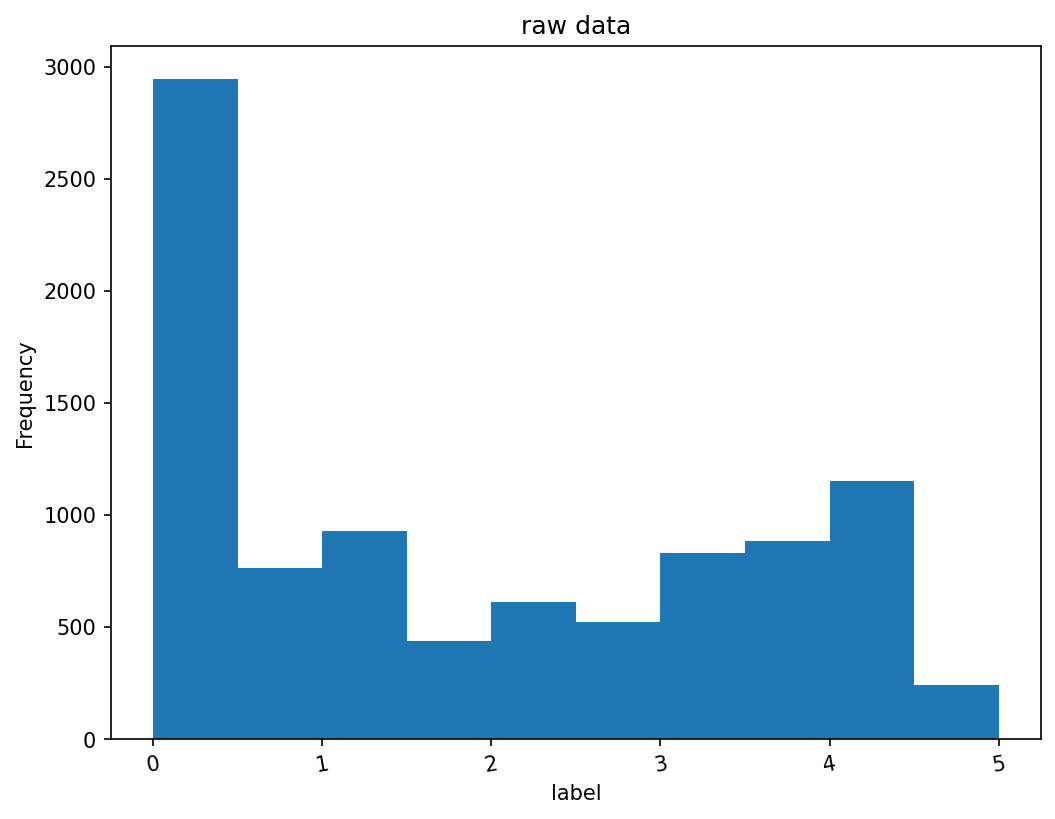

In [43]:
import matplotlib.pyplot as plt
# raw data의 분포 재확인
labels = train_df['label']

plt.figure(dpi=150)
ax = labels.plot(kind='hist', rot=10, figsize=(8,6))
ax.set_title("raw data")
ax.set_xlabel("label")
plt.show()

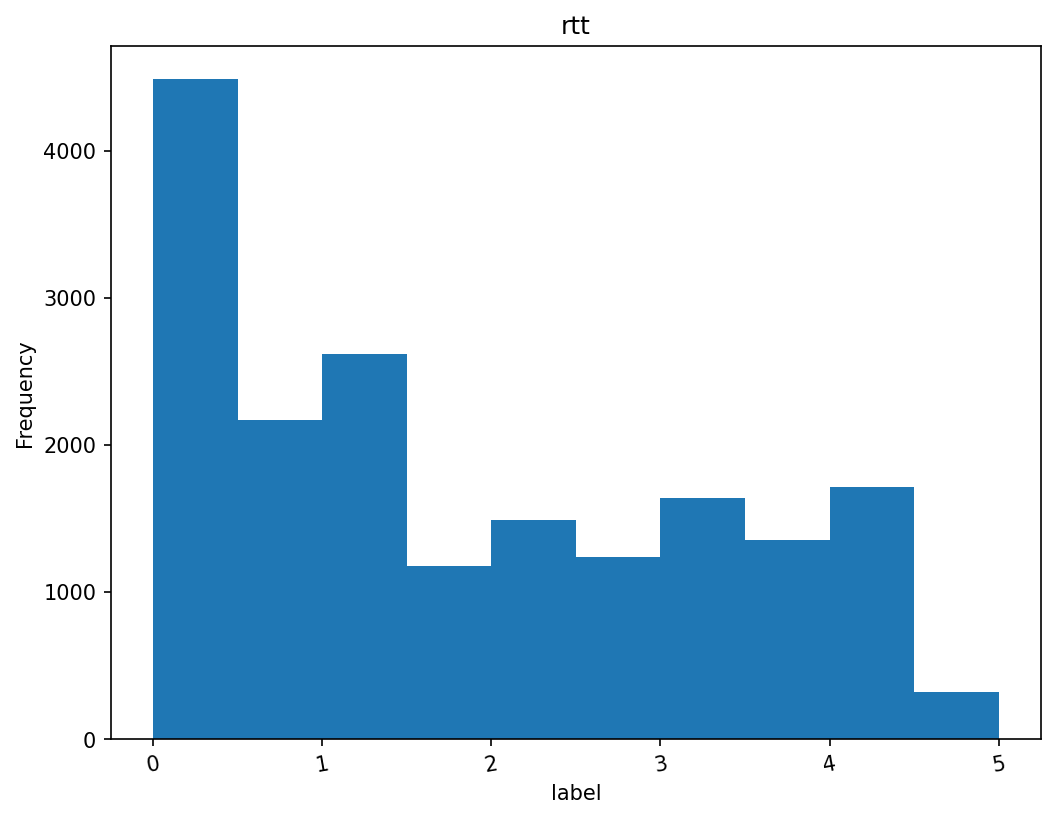

In [47]:
# rtt의 분포 확인
labels = train1_df['label']
plt.figure(dpi=150)
ax = labels.plot(kind='hist', rot=10, figsize=(8,6))
ax.set_title("rtt")
ax.set_xlabel("label")
plt.show()

RTT 처리로 인해 0.0과 5.0 사이의 데이터가 2배로 증가하여, 분포가 상대적으로 조금 균일해졌다.

Swap 처리한 데이터의 경우는 굳이 확인하지 않겠다.

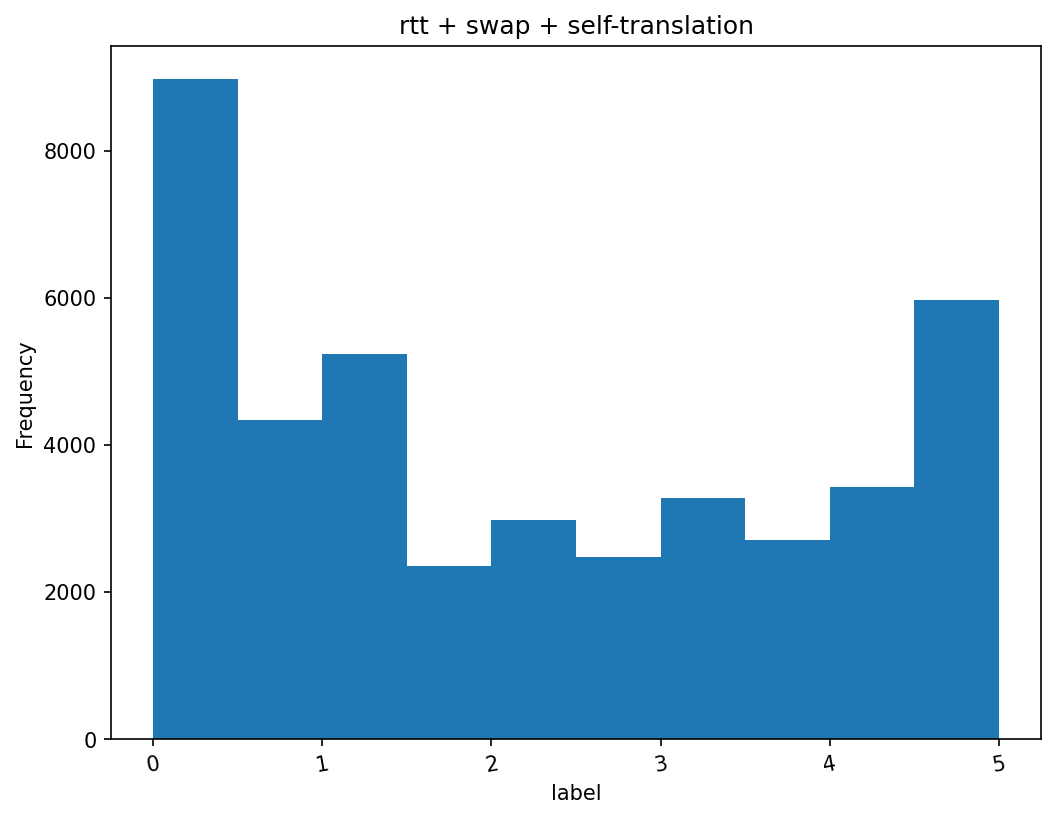

In [49]:
# RTT + Swap + self-translation의 분포 확인
labels = train3_df['label']

plt.figure(dpi=150)
ax = labels.plot(kind='hist', rot=10, figsize=(8,6))
ax.set_title("rtt + swap + self-translation")
ax.set_xlabel("label")
plt.show()

위와 같이, 3가지 DA 기법을 적용한 데이터에 대한 label의 분포는 Skewed distribution에서 비교적 완만한 bimodal distribution으로 바뀌게 되었다. 

이제 남은 것은 각 증강된 데이터를 가지고 학습했을 때 유의미한 효과가 있는지를 관찰하기만 하면 된다!

In [52]:
train_df[train_df['source'].str.contains("rtt")].sample(20)

,id,source,sentence_1,sentence_2,label,binary-label
4214,boostcamp-sts-v1-train-4214,petition-rtt,세무서 직무 유기로 민원인 소송비용 손해 와 조세 징수 우선권 에 대한 청원,세무서 업무포기로 인한 공무원 소송비용 손실 및 징수우선순위 청원,2.8,1.0
4799,boostcamp-sts-v1-train-4799,petition-rtt,"기간제(전일제,시간제) 교사에 대하여","기간제(전일제, 시간제) 교사에 대해",5.0,1.0
1587,boostcamp-sts-v1-train-1587,slack-rtt,환영의 이모지 많이많이 부탁드려요 !!,환영 이모티콘 많이 보내주세요 !!,4.0,1.0
3447,boostcamp-sts-v1-train-3447,slack-rtt,헐 ㅋㅋ 이런걸 하시다니 멋있군요.,"이봐, 당신이 이것을하고있는 것이 좋습니다.",1.6,0.0
6262,boostcamp-sts-v1-train-6262,slack-rtt,<PERSON> 님과 입사 이후로 오랜만에 만나서 얘기나누었습니다.,입사 후 오랜만에 <PERSON>을 만나 이야기를 나눴다.,4.4,1.0
2239,boostcamp-sts-v1-train-2239,nsmc-rtt,맨날 느와르 코믹에 시덥잖은 공포영화나 만들고 센송합니다...,매일매일 느와르만화로 지루한 공포영화를 만들고...,2.2,0.0
4291,boostcamp-sts-v1-train-4291,petition-rtt,경기도 양주시 종합병원 설립이 왜 어려운건가요,경기도 양주에 종합병원 설립이 어려운 이유는?,3.8,1.0
7326,boostcamp-sts-v1-train-7326,slack-rtt,스우파로 대동단결...,수파와 연대,0.6,0.0
2450,boostcamp-sts-v1-train-2450,slack-rtt,우선 U 밑에 점은 제외하고 첨부 이미지와 같이 사용하려 합니다.,우선 U 아래에 있는 점을 제외하고는 첨부된 이미지와 같이 사용하고 싶습니다.,3.8,1.0
8290,boostcamp-sts-v1-train-8290,nsmc-rtt,평점 쓰레기로 준 애들은 무슨 캐 휴먼드라마나 캐감동을 기대했냐? 아님 섹씬?,쓰레기라고 평가했던 아이들은 어떤 휴먼 드라마나 드라마를 기대했을까요? 아니면 섹시?,4.0,1.0


id              boostcamp-sts-v1-train-001
source                           slack-rtt
sentence_1            앗 제가 접근권한이 없다고 뜹니다;;
sentence_2             오, 액세스 권한이 없다고 합니다.
label                                  4.2
binary-label                           1.0
Name: 1, dtype: object